
# Bulid a Live Camera App
---

## Step 1 : Data Exploration


### Download
 
This notebook uses the [SVHN](http://ufldl.stanford.edu/housenumbers/) dataset to be used with python experiments.  
SVHN dataset is a good large scale dataset collected from house numbers in Google Street View.

In [14]:
# These are all the modules I'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import urllib
import cPickle as pickle
import scipy.io as sio
import h5py
import random

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [15]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def download_data(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print('Failed to verify ' + filename + 'Can you get to it with a browser?')
  return filename

train_filename = download_data('train.tar.gz', 404141560)
test_filename = download_data('test.tar.gz', 276555967)
extra_filename = download_data('extra.tar.gz', 1955489752)

cropped_train_filename = download_data('train_32x32.mat', 182040794)
cropped_test_filename = download_data('test_32x32.mat', 64275384)
cropped_extra_filename = download_data('extra_32x32.mat', 1329278602)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz
Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat


Extract the dataset from the compressed .tar.gz file.

In [16]:
def extract_data(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]
  if os.path.isdir(root) and not force:
    print('%s already present - Skipping extra of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  return root

train_folders = extract_data(train_filename)
test_folders = extract_data(test_filename)
extra_folders = extract_data(extra_filename)

train already present - Skipping extra of train.tar.gz.
test already present - Skipping extra of test.tar.gz.
extra already present - Skipping extra of extra.tar.gz.


--------


### Displaying a sample of the labels and images

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [18]:
%matplotlib inline
 
def show_random(datasets, n): 
    fig = plt.figure()
    fig.set_size_inches(10, 5)
    
    for idx, vals in enumerate(datasets):
        try:
            with open(vals, "rb") as f:
                fonts = pickle.load(f)
            sample = random.sample(range(len(fonts)), n)

            label = letter.split('/')[1]
            title = '%s\nsample: %s' % (label, str(n))

            a=fig.add_subplot(2,5,idx+1)
            a.set_title(title)

            for img in sample:
                plt.imshow(fonts[img], cmap=plt.cm.gray)
                
        except Exception as e:
            print('Unable to process data from:', vals, '||', e)
            
    plt.show()

show_random(train_folders, 10)
show_random(test_folders, 10)

Unable to process data from: t || [Errno 2] No such file or directory: 't'
Unable to process data from: r || [Errno 2] No such file or directory: 'r'
Unable to process data from: a || [Errno 2] No such file or directory: 'a'
Unable to process data from: i || [Errno 2] No such file or directory: 'i'
Unable to process data from: n || [Errno 2] No such file or directory: 'n'


Unable to process data from: t || [Errno 2] No such file or directory: 't'
Unable to process data from: e || [Errno 2] No such file or directory: 'e'
Unable to process data from: s || [Errno 2] No such file or directory: 's'
Unable to process data from: t || [Errno 2] No such file or directory: 't'


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [10]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [12]:
import time
import hashlib

t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train = np.in1d(test_hashes, train_hashes)
test_in_valid = np.in1d(test_hashes, valid_hashes)

valid_keep = ~valid_in_train
test_keep = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean = valid_labels[valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean = test_labels[test_keep]

t2 = time.time()

print("Time: %0.2fs" % (t2 - t1))
print("valid -> train overlap : %d samples" % valid_in_train.sum())
print("test -> train overlap : %d samples" % test_in_train.sum())
print("test -> valid overlap : %d samples" % test_in_valid.sum())


Time: 1.75s
valid -> train overlap : 1067 samples
test -> train overlap : 1324 samples
test -> valid overlap : 200 samples


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

0.8387

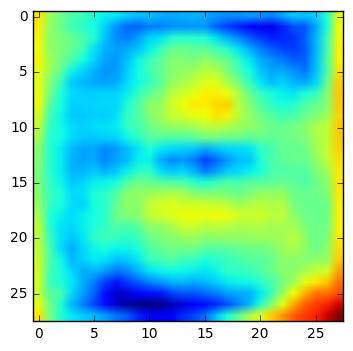

In [16]:
def training_sample(num):
        num_samples = num
        n_classes = 10

        (samples, width, height) = train_dataset.shape
        X = np.reshape(train_dataset,(samples, width*height))[0:num_samples]
        y = train_labels[0:num_samples]

        # This gives a nice image of a letter
        example = X.reshape(num_samples, width, height)[0]
        plt.imshow(example)

        clf = LogisticRegression(C=0.001)
        clf.fit(X, y)

        (samples, width, height) = test_dataset.shape
        X_test = np.reshape(test_dataset, (samples, width*height))
        y_test = test_labels
        answer = clf.score(X_test, y_test)

        # This gives a totally random looking image, but I expect it should 
        # look like a fuzzy kind of letter.  
        filter_a = clf.coef_.reshape(n_classes, width, height)[0]
        plt.imshow(filter_a)
        
        return (answer)
        
training_sample(1000)
